In [ ]:
import pandas as pd
# Set the display options
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)  # None means unlimited
from sklearn.model_selection import train_test_split


In [ ]:
# df_clinical_full = pd.read_csv('/local/scratch/shared-directories/ssanet/Dataset_EMBED/tables/EMBED_OpenData_clinical.csv',index_col=0)
df_clinical_reduced = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_clinical_reduced.csv',index_col=0)
# df_opendata_metadata = pd.read_csv('/local/scratch/shared-directories/ssanet/Dataset_EMBED/tables/EMBED_OpenData_metadata.csv',index_col=0)
df_opendata_metadata_reduced = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_metadata_reduced.csv',index_col=0)

/tmp/ipykernel_2043213/3054053678.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clinical_reduced = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_clinical_reduced.csv',index_col=0)
/tmp/ipykernel_2043213/3054053678.py:4: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opendata_metadata_reduced = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_metadata_reduced.csv',index_col=0)


In [ ]:
df_clinical_reduced['asses'].value_counts()

asses
N    45972
B    15018
A    11425
P     5570
S     3085
K      395
M      285
X       26
Name: count, dtype: int64

In [ ]:
# print(df_clinical_full.shape)
# print(df_opendata_metadata.shape)

print(df_clinical_reduced.shape)
print(df_opendata_metadata_reduced.shape)

(81776, 20)
(480323, 28)


In [ ]:
print(len(df_clinical_reduced['empi_anon'].unique()))

23253


In [ ]:
df_clinical_reduced['numfind'].value_counts()

numfind
1    73357
2     6697
3     1307
4      300
5       76
6       24
7        9
8        4
0        1
9        1
Name: count, dtype: int64

In [ ]:
df_clinical_reduced = df_clinical_reduced[df_clinical_reduced['numfind']==1]
df_clinical_reduced.shape

(73357, 20)

In [ ]:
df_clinical_reduced_side_L = df_clinical_reduced[df_clinical_reduced['side']=='L']
df_clinical_reduced_side_R = df_clinical_reduced[df_clinical_reduced['side']=='R']
df_clinical_reduced_side_B = df_clinical_reduced[df_clinical_reduced['side']=='B']
df_clinical_reduced_side_nan = df_clinical_reduced[df_clinical_reduced['side'].isna()]


df_opendata_metadata_reduced_L = df_opendata_metadata_reduced[df_opendata_metadata_reduced['ImageLateralityFinal']=='L']
df_opendata_metadata_reduced_R = df_opendata_metadata_reduced[df_opendata_metadata_reduced['ImageLateralityFinal']=='R']

print("(Just to verify) Combined length of divided Metadata: ", len(df_opendata_metadata_reduced_L)+len(df_opendata_metadata_reduced_R))
print("(Just to verify) Combined length of divided ClinicalData: ", (len(df_clinical_reduced_side_L)+len(df_clinical_reduced_side_R)+len(df_clinical_reduced_side_B)+len(df_clinical_reduced_side_nan)))

(Just to verify) Combined length of divided Metadata:  480323
(Just to verify) Combined length of divided ClinicalData:  73357


In [ ]:
df_opendata_metadata_reduced_L = df_opendata_metadata_reduced_L.groupby(['empi_anon', 'acc_anon']).agg(lambda x: list(x)).reset_index()
agg_dict = {col: lambda x: list(x) for col in df_opendata_metadata_reduced_L.columns if col not in ['empi_anon', 'acc_anon']}
df_opendata_metadata_reduced_L = df_opendata_metadata_reduced_L.groupby(['empi_anon', 'acc_anon']).agg(agg_dict).reset_index()

df_opendata_metadata_reduced_R = df_opendata_metadata_reduced_R.groupby(['empi_anon', 'acc_anon']).agg(lambda x: list(x)).reset_index()
agg_dict = {col: lambda x: list(x) for col in df_opendata_metadata_reduced_R.columns if col not in ['empi_anon', 'acc_anon']}
df_opendata_metadata_reduced_R = df_opendata_metadata_reduced_R.groupby(['empi_anon', 'acc_anon']).agg(agg_dict).reset_index()

df_opendata_metadata_reduced_LR = df_opendata_metadata_reduced.groupby(['empi_anon', 'acc_anon']).agg(lambda x: list(x)).reset_index()
agg_dict = {col: lambda x: list(x) for col in df_opendata_metadata_reduced_LR.columns if col not in ['empi_anon', 'acc_anon']}
df_opendata_metadata_reduced_LR = df_opendata_metadata_reduced_LR.groupby(['empi_anon', 'acc_anon']).agg(agg_dict).reset_index()


In [ ]:
final_side_L_with_image = pd.merge(df_clinical_reduced_side_L, df_opendata_metadata_reduced_L, on=['empi_anon', 'acc_anon'], how='inner')
final_side_R_with_image = pd.merge(df_clinical_reduced_side_R, df_opendata_metadata_reduced_R, on=['empi_anon', 'acc_anon'], how='inner')
final_side_B_with_image = pd.merge(df_clinical_reduced_side_B, df_opendata_metadata_reduced_LR, on=['empi_anon', 'acc_anon'], how='inner')
final_side_nan_with_image = pd.merge(df_clinical_reduced_side_nan, df_opendata_metadata_reduced_LR, on=['empi_anon', 'acc_anon'], how='inner')

In [ ]:
final_dataset_with_images = pd.concat([final_side_R_with_image, final_side_L_with_image, final_side_B_with_image, final_side_nan_with_image], axis=0).reset_index(drop=True)

In [ ]:
final_dataset_with_images = final_dataset_with_images[final_dataset_with_images['asses']!='X'].reset_index(drop=True)
final_dataset_with_images['asses'].replace({'P':'M','S':'M','K':'M'},inplace=True)
final_dataset_with_images['asses'].value_counts()

asses
N    45276
B    11968
A     9167
M     6898
Name: count, dtype: int64

In [ ]:
test_size = 0.10  # 10% for the test set
validation_size = 0.20  # 20% of the remaining data for the validation set
train_df, test_df = train_test_split(final_dataset_with_images, test_size=test_size, stratify=final_dataset_with_images['asses'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=validation_size, stratify=train_df['asses'], random_state=42)
print("train set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("test set size:", test_df.shape)

train set size: (52782, 46)
Validation set size: (13196, 46)
test set size: (7331, 46)


In [ ]:
train_df.to_csv('train.csv',index=False)
test_df.to_csv('test.csv',index=False)
val_df.to_csv('val.csv',index=False)

In [ ]:
train_df['asses'].value_counts()

asses
N    32599
B     8617
A     6600
M     4966
Name: count, dtype: int64

In [ ]:
val_df['asses'].value_counts()

asses
N    8150
B    2154
A    1650
M    1242
Name: count, dtype: int64

In [ ]:
train_df.sample(4)

NameError: name 'train_df' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv('train.csv')

In [ ]:
df['asses'].value_counts()

asses
N    32599
B     8617
A     6600
M     4966
Name: count, dtype: int64

In [ ]:
df.sample(3)

,empi_anon,acc_anon,desc,numfind,side,asses,tissueden,bside,GENDER_DESC,RACE_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,study_date_anon_x,procdate_anon,cohort_num_x,path_severity,total_L_find,total_R_find,first_3_zip,cohort_num_y,study_date_anon_y,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,anon_dicom_path,num_roi,ROI_coords,SRC_DST,match_level,Manufacturer,ManufacturerModelName,PatientSex,ProtocolName,SeriesNumber,SeriesTime,StudyID,WindowCenter,WindowWidth,has_pix_array,category,VOILUTFunction,WindowCenterWidthExplanation
12464,94523498,9222653435392327,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,NaN,N,2.0,NaN,Female,Asian,Non-Hispanic or Latino,Not Recorded,64.255940,2018-06-25,NaN,1,NaN,0.0,0.0,305.0,"[[1, 1, 1, 1, 1, 1, 1, 1]]","[['2018-06-25 00:00:00', '2018-06-25 00:00:00'...","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['R CC C-View', 'R CC', 'L CC C-View', 'L CC'...","[['cview', '2D', 'cview', '2D', '2D', 'cview',...","[['R', 'R', 'L', 'L', 'L', 'R', 'R', 'L']]","[['CC', 'CC', 'CC', 'CC', 'MLO', 'MLO', 'MLO',...","[[nan, nan, nan, nan, nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_1/9452349...,"[[0, 0, 0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()', '()', '(...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']]","[['R CC ComboHD', 'R CC ComboHD', 'L CC ComboH...","[[71300000, 71300000, 71300000, 71300000, 7130...","[[161140.0, 161140.0, 161243.0, 161243.0, 1615...","[['MG Screen Bilat', 'MG Screen Bilat', 'MG Sc...","[['540.0', '2047.0', '540.0', '2047.0', '2047....","[['580.0', '4096.0', '580.0', '4096.0', '4096....","[[False, False, False, False, False, False, Fa...","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan, nan, nan]]"
43145,96915713,1035206825807615,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,NaN,N,3.0,NaN,Female,Caucasian or White,Non-Hispanic or Latino,Married,58.314681,2019-11-06,NaN,1,NaN,0.0,0.0,303.0,"[[1, 1, 1, 1, 1, 1, 1, 1]]","[['2019-11-06 00:00:00', '2019-11-06 00:00:00'...","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['L MLO', 'L CC', 'L CC C-View', 'L MLO C-Vie...","[['2D', '2D', 'cview', 'cview', '2D', 'cview',...","[['L', 'L', 'L', 'L', 'R', 'R', 'R', 'R']]","[['MLO', 'CC', 'CC', 'MLO', 'CC', 'MLO', 'CC',...","[[nan, nan, nan, nan, nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_1/9691571...,"[[0, 0, 0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()', '()', '(...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']]","[['L MLO ComboHD', 'L CC ComboHD', 'L CC Combo...","[[71300000, 71300000, 71300000, 71300000, 7130...","[[135020.0, 134501.0, 134501.0, 135020.0, 1346...","[['MG Screen Bilat', 'MG Screen Bilat', 'MG Sc...","[['2047.0', '2047.0', '540.0', '540.0', '2047....","[['4096.0', '4096.0', '580.0', '580.0', '4096....","[[False, False, False, False, False, False, Fa...","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan, nan, nan]]"
36960,44786342,5358334024912056,MG Screening Bilateral,1,NaN,N,2.0,NaN,Female,Asian,Non-Hispanic or Latino,Married,67.284065,2013-05-02,NaN,2,NaN,0.0,0.0,300.0,"[[2, 2, 2, 2]]","[['2013-05-02 00:00:00', '2013-05-02 00:00:00'...","[['MG Screening Bilateral', 'MG Screening Bila...","[['MG Screening Digital Bilateral', 'MG Screen...","[['2D', '2D', '2D', '2D']]","[['L', 'R', 'L', 'R']]","[['CC', 'MLO', 'MLO', 'CC']]","[[nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_2/4478634...,"[[

In [ ]:
df['path_severity'].unique()

array([nan,  4.,  0.,  1.,  3.,  2.,  5.])

In [ ]:
df['path_severity'].value_counts()

path_severity
4.0    1205
0.0     588
2.0     355
1.0     242
3.0      28
5.0      21
Name: count, dtype: int64

In [ ]:
len(df)

52782

In [ ]:
df['path_severity'].isna().sum()

50343

In [ ]:
# df[df.sort_values(by='empi_anon')]['asses']=='B'
df[df['asses']=='B'].sort_values(by='empi_anon').head(5)
# 10015693,
# 10033806: B,
# 10042753: B,
# 10043985: B,

,empi_anon,acc_anon,desc,numfind,side,asses,tissueden,bside,GENDER_DESC,RACE_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,study_date_anon_x,procdate_anon,cohort_num_x,path_severity,total_L_find,total_R_find,first_3_zip,cohort_num_y,study_date_anon_y,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,anon_dicom_path,num_roi,ROI_coords,SRC_DST,match_level,Manufacturer,ManufacturerModelName,PatientSex,ProtocolName,SeriesNumber,SeriesTime,StudyID,WindowCenter,WindowWidth,has_pix_array,category,VOILUTFunction,WindowCenterWidthExplanation
43699,10033806,1069386741434572,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,R,B,3.0,NaN,Female,Asian,Non-Hispanic or Latino,Married,49.137217,2019-10-05,NaN,1,NaN,0.0,1.0,300.0,"[[1, 1, 1, 1, 1, 1]]","[['2019-10-05 00:00:00', '2019-10-05 00:00:00'...","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['R MLO', 'R CC', 'R CC C-View', 'R MLO C-Vie...","[['2D', '2D', 'cview', 'cview', '2D', '2D']]","[['R', 'R', 'R', 'R', 'R', 'R']]","[['MLO', 'CC', 'CC', 'MLO', 'XCCL', 'MLO']]","[[nan, nan, nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1003380...,"[[0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()']]","[['[]', '[]', '[]', '[]', '[]', '[]']]","[['[]', '[]', '[]', '[]', '[]', '[]']]","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F']]","[['R MLO', 'R CC ComboHD', 'R CC ComboHD', 'R ...","[[71100000, 71300000, 71300000, 71300000, 7110...","[[83207.0, 75914.0, 75914.0, 80321.0, 80014.0,...","[['MG Screen Bilat', 'MG Screen Bilat', 'MG Sc...","[['2047.0', '2047.0', '540.0', '540.0', '2047....","[['4096.0', '4096.0', '580.0', '580.0', '4096....","[[False, False, False, False, False, False]]","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan]]"
44018,10042753,1906889894591967,MG Diagnostic Bilateral w/ CAD,1,L,B,2.0,NaN,Female,Caucasian or White,Non-Hispanic or Latino,Married,73.904324,2018-05-13,NaN,2,NaN,1.0,0.0,302.0,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]","[['2018-05-13 00:00:00', '2018-05-13 00:00:00'...","[['MG Diagnostic Bilateral w/ CAD', 'MG Diagno...","[['L CC C-View', 'L ML C-View', 'L MLO C-View'...","[['cview', 'cview', 'cview', '2D', '2D', '2D',...","[['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L',...","[['CC', 'ML', 'MLO', 'CC', 'ML', 'CC', 'CC', '...","[[nan, nan, nan, 1.0, nan, nan, nan, nan, nan,...",[['/mnt/NAS2/mammo/anon_dicom/cohort_2/1004275...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()', '()', '(...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',...","[['L CC ComboHD', 'L ML ComboHD', 'L MLO Combo...","[[71300000, 71300000, 71300000, 71100000, 7130...","[[131300.0, 131604.0, 131425.0, 125224.0, 1316...","[['MG Diagnostic Bi', 'MG Diagnostic Bi', 'MG ...","[['540.0', '540.0', '540.0', '2047.0', '2047.0...","[['580.0', '580.0', '580.0', '4096.0', '4096.0...","[[False, False, False, False, False, False, Fa...","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
42106,10043985,1960584382049532,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,R,B,2.0,NaN,Female,African American or Black,Non-Hispanic or Latino,Married,60.858197,2018-04-18,NaN,2,NaN,0.0,1.0,303.0,"[[2, 2]]","[['2018-04-18 00:00:00', '2018-04-18 00:00:00']]","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['R CC', 'R MLO']]","[['2D', '2D']]","[['R', 'R']]","[['CC', 'MLO']]","[[nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_2/1004398...,"[[0, 0]]","[['()', '()']]","[['[]', '[]']]","[['[]', '[]']]","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.']]","[['Selenia Dimensions', 'Selen

In [ ]:
import pandas as pd
df = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/test.csv')

In [ ]:
def convert_to_list(string):
    # Remove the outer brackets and split by ', '
    return string.strip("[]").replace("'", "").split(", ")

df['anon_dicom_path'] = df['anon_dicom_path'].apply(convert_to_list)


def replace_path_prefix(paths, cohort_keywords=['/cohort_1', 'cohort_2']):
    new_prefix = '/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/'
    updated_paths = []

    for path in paths:
        # Replace the part of the path before the cohort keyword
        for keyword in cohort_keywords:
            if keyword in path:
                split_path = path.split(keyword)
                updated_path = new_prefix + keyword.lstrip('/') + split_path[1]
                updated_paths.append(updated_path)
                break
        else:
            # If no cohort keyword is found, keep the path as is
            updated_paths.append(path)

    return updated_paths

df['anon_dicom_path'] = df['anon_dicom_path'].apply(replace_path_prefix)



In [ ]:
df.sample(1)['anon_dicom_path'].values

array([list(['/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/81968839/1.2.841.113976.3.63.1.53752039.20161013.1100763/1.2.847.113684.2750824498.1475823847.4269.79708.1/1.2.826.0.1.3680043.8.498.97914458751969773645522327507542628395.dcm', '/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/81968839/1.2.841.113976.3.63.1.53752039.20161013.1100763/1.2.849.113682.2750824506.1475823843.4261.79724.1/1.2.826.0.1.3680043.8.498.86482261799939862849767242593468041429.dcm', '/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/81968839/1.2.841.113976.3.63.1.53752039.20161013.1100763/1.2.848.113682.2750824501.1475823844.4269.79696/1.2.826.0.1.3680043.8.498.10384586188404653933369878451561834040.dcm', '/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/81968839/1.2.841.113976.3.63.1.53752039.20161013.1100763/1.2.847.113688.2750824502.1475823845.4260.79711/1.2.826.0.1.3680043.8.498.29499166944578956862

In [ ]:
df.head()['anon_dicom_path'].values[1]

['/mnt/NAS2/mammo/anon_dicom/cohort_2/69886802/1.2.841.113972.3.59.1.49011832.20140225.1091614/1.2.844.113628.2.67.2198800770.7638140220095637.10005/1.2.826.0.1.3680043.8.498.14887150938636124287792360088186723626.dcm',
 '/mnt/NAS2/mammo/anon_dicom/cohort_2/69886802/1.2.841.113972.3.59.1.49011832.20140225.1091614/1.2.844.113628.2.67.2198800770.7638140220095637.10005/1.2.826.0.1.3680043.8.498.13074859188686048180351460395477580363.dcm',
 '/mnt/NAS2/mammo/anon_dicom/cohort_2/69886802/1.2.841.113972.3.59.1.49011832.20140225.1091614/1.2.844.113628.2.67.2198800770.7638140220095637.10005/1.2.826.0.1.3680043.8.498.26807824134913992826961520446915946310.dcm']

In [ ]:
df = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/train.csv')

In [ ]:
df.sample(2
          )

,empi_anon,acc_anon,desc,numfind,side,asses,tissueden,bside,GENDER_DESC,RACE_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,study_date_anon_x,procdate_anon,cohort_num_x,path_severity,total_L_find,total_R_find,first_3_zip,cohort_num_y,study_date_anon_y,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,anon_dicom_path,num_roi,ROI_coords,SRC_DST,match_level,Manufacturer,ManufacturerModelName,PatientSex,ProtocolName,SeriesNumber,SeriesTime,StudyID,WindowCenter,WindowWidth,has_pix_array,category,VOILUTFunction,WindowCenterWidthExplanation
12188,86911238,4857638682755195,MG Diagnostic Bilateral w/ CAD,1,B,N,2.0,NaN,Male,African American or Black,Non-Hispanic or Latino,Married,67.790577,2017-01-10,NaN,2,NaN,1.0,1.0,300.0,"[[2, 2, 2, 2, 2, 2, 2, 2]]","[['2017-01-10 00:00:00', '2017-01-10 00:00:00'...","[['MG Diagnostic Bilateral w/ CAD', 'MG Diagno...","[['L CC', 'L XCCL', 'R CC', 'L XCCL', 'R XCCL'...","[['2D', '2D', '2D', '2D', '2D', '2D', '2D', '2...","[['L', 'L', 'R', 'L', 'R', 'L', 'L', 'R']]","[['CC', 'XCCL', 'CC', 'XCCL', 'XCCL', 'MLO', '...","[[nan, nan, nan, nan, nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_2/8691123...,"[[0, 0, 0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()', '()', '(...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']]","[['L CC', 'L XCCL', 'R CC', 'L XCCL', 'R XCCL'...","[[71100000, 71100000, 71100000, 71100000, 7110...","[[85332.0, 85517.0, 84904.0, 85439.0, 85014.0,...","[['MG Diagnostic Ma', 'MG Diagnostic Ma', 'MG ...","[['2047.0', '2047.0', '2047.0', '2047.0', '204...","[['4096.0', '4096.0', '4096.0', '4096.0', '409...","[[False, False, False, False, False, False, Fa...","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan, nan, nan]]"
52053,29322854,6711012431317963,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,NaN,N,3.0,NaN,Female,Caucasian or White,Non-Hispanic or Latino,Married,70.528485,2018-12-24,NaN,2,NaN,0.0,0.0,306.0,"[[2, 2, 2, 2, 2, 2, 2, 2]]","[['2018-12-24 00:00:00', '2018-12-24 00:00:00'...","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['L CC C-View', 'L MLO C-View', 'R CC C-View'...","[['cview', 'cview', 'cview', 'cview', '2D', '2...","[['L', 'L', 'R', 'R', 'L', 'R', 'R', 'L']]","[['CC', 'MLO', 'CC', 'MLO', 'CC', 'CC', 'MLO',...","[[nan, nan, nan, nan, nan, nan, nan, nan]]",[['/mnt/NAS2/mammo/anon_dicom/cohort_2/2932285...,"[[0, 0, 0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()', '()', '(...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[...","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']]","[['L CC ComboHD', 'L MLO ComboHD', 'R CC Combo...","[[71300000, 71300000, 71300000, 71300000, 7130...","[[111327.0, 111948.0, 111211.0, 111757.0, 1113...","[['MG Screen Bilat', 'MG Screen Bilat', 'MG Sc...","[['540.0', '540.0', '540.0', '540.0', '2047.0'...","[['580.0', '580.0', '580.0', '580.0', '4096.0'...","[[False, False, False, False, False, False, Fa...","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan, nan, nan]]"


In [ ]:
df['side'].value_counts()

side
L    10925
R    10676
B     2302
Name: count, dtype: int64

In [ ]:
df_l = df[df['side']=='L']
df_l = df_l.sample(2)

In [ ]:
df_l

,empi_anon,acc_anon,desc,numfind,side,asses,tissueden,bside,GENDER_DESC,RACE_DESC,ETHNIC_GROUP_DESC,MARITAL_STATUS_DESC,age_at_study,study_date_anon_x,procdate_anon,cohort_num_x,path_severity,total_L_find,total_R_find,first_3_zip,cohort_num_y,study_date_anon_y,StudyDescription,SeriesDescription,FinalImageType,ImageLateralityFinal,ViewPosition,spot_mag,anon_dicom_path,num_roi,ROI_coords,SRC_DST,match_level,Manufacturer,ManufacturerModelName,PatientSex,ProtocolName,SeriesNumber,SeriesTime,StudyID,WindowCenter,WindowWidth,has_pix_array,category,VOILUTFunction,WindowCenterWidthExplanation
9946,76276880,8716913674935807,MG Screen Bilat w/Tomo/CAD Stnd Protocol,1,L,A,2.0,NaN,Female,Caucasian or White,Hispanic or Latino,Divorced,51.855959,2017-08-31,NaN,1,NaN,1.0,3.0,302.0,"[[1, 1, 1, 1, 1, 1]]","[['2017-08-31 00:00:00', '2017-08-31 00:00:00'...","[['MG Screen Bilat w/Tomo/CAD Stnd Protocol', ...","[['L CC C-View', 'L CC', 'L MLO', 'L MLO C-Vie...","[['cview', '2D', '2D', 'cview', '2D', '2D']]","[['L', 'L', 'L', 'L', 'L', 'L']]","[['CC', 'CC', 'MLO', 'MLO', 'MLO', 'XCCL']]","[[nan, nan, nan, nan, nan, nan]]",[/local/scratch/shared-directories/ssanet/embe...,"[[0, 0, 0, 0, 0, 0]]","[['()', '()', '()', '()', '()', '()']]","[['[]', '[]', '[]', '[]', '[]', '[]']]","[['[]', '[]', '[]', '[]', '[]', '[]']]","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F', 'F', 'F', 'F']]","[['L CC ComboHD', 'L CC ComboHD', 'L MLO Combo...","[[71300000, 71300000, 71300000, 71300000, 7110...","[[102635.0, 102635.0, 102822.0, 102822.0, 1029...","[['MG Screening Dig', 'MG Screening Dig', 'MG ...","[['540.0', '2047.0', '2047.0', '540.0', '2047....","[['580.0', '4096.0', '4096.0', '580.0', '4096....","[[False, False, False, False, False, False]]","[['no image', 'no image', 'no image', 'no imag...","[[nan, nan, nan, nan, nan, nan]]","[[nan, nan, nan, nan, nan, nan]]"
36639,66786013,5403651027278069,MG Screening Bilateral w/CAD,1,L,A,2.0,NaN,Female,African American or Black,Non-Hispanic or Latino,Single,59.371513,2013-10-05,NaN,1,NaN,2.0,1.0,303.0,"[[1, 1, 1]]","[['2013-10-05 00:00:00', '2013-10-05 00:00:00'...","[['MG Screening Bilateral w/CAD', 'MG Screenin...","[['L CC', 'L MLO', 'L XCCL']]","[['2D', '2D', '2D']]","[['L', 'L', 'L']]","[['CC', 'MLO', 'XCCL']]","[[nan, nan, nan]]",[/local/scratch/shared-directories/ssanet/embe...,"[[0, 0, 0]]","[['()', '()', '()']]","[['[]', '[]', '[]']]","[['[]', '[]', '[]']]","[['HOLOGIC, Inc.', 'HOLOGIC, Inc.', 'HOLOGIC, ...","[['Selenia Dimensions', 'Selenia Dimensions', ...","[['F', 'F', 'F']]","[['LCC', 'LMLO', 'LXCCL']]","[[71100000, 71100000, 71100000]]","[[144200.0, 144638.0, 144400.0]]","[['MG Screening Dig', 'MG Screening Dig', 'MG ...","[['2047.0', '2047.0', '2047.0']]","[['4096.0', '4096.0', '4096.0']]","[[False, False, False]]","[['no image', 'no image', 'no image']]","[[nan, nan, nan]]","[[nan, nan, nan]]"


In [ ]:
df_l['anon_dicom_path']


9946     [/local/scratch/shared-directories/ssanet/embe...
36639    [/local/scratch/shared-directories/ssanet/embe...
Name: anon_dicom_path, dtype: object

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pydicom
import skimage.exposure as exposure


def preprocess_dicom_image(dicom_path):
    dicom = pydicom.read_file(dicom_path)
    image = dicom.pixel_array * dicom.RescaleSlope + dicom.RescaleIntercept
    image = np.nan_to_num(image)
    image = (image - image.min()) / (image.max() - image.min())
    p2, p98 = np.percentile(image, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    # convert to grayscale using plt
    image = plt.cm.gray(image)
    plt.imsave('test.png', image)
    return image


def aggregate_images(image_list):
    return np.mean(np.stack(image_list, axis=0), axis=0)

df_l['image_arrays'] = df_l['anon_dicom_path'].apply(lambda x: aggregate_images([preprocess_dicom_image(path) for path in x]) if isinstance(x, list) else np.zeros((224, 224)))

In [ ]:
import pydicom
from PIL import Image
import numpy as np
import pandas as pd
import os

def dicom_to_png(dicom_file, output_folder):
    """
    Convert a DICOM file to a grayscale PNG image.
    """
    # Load the DICOM image
    ds = pydicom.dcmread(dicom_file)

    # Get the pixel array from the DICOM object
    image_data = ds.pixel_array

    # Normalize or scale the image data to be in the range of 0-255
    image_data = (np.maximum(image_data, 0) / image_data.max()) * 255.0
    image_data = np.uint8(image_data)

    # Convert to a PIL image and save as PNG
    image = Image.fromarray(image_data)
    png_filename = os.path.join(output_folder, os.path.basename(dicom_file).replace('.dcm', '.png'))
    image.save(png_filename)

    return png_filename



output_folder = '/local/scratch/shared-directories/ssanet/SCRIPTS'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Apply the conversion to each DICOM image in each list
for index, row in df_l.iterrows():
    for dicom_path in row['anon_dicom_path']:
        png_path = dicom_to_png(dicom_path, output_folder)
        print(f"Converted {dicom_path} to {png_path}")


Converted /local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/76276880/1.2.841.113974.3.57.1.54789586.20170422.1100368/1.2.848.113688.2750824498.1492497423.4204.19097.1/1.2.826.0.1.3680043.8.498.65264159218472449111114878745003398346.dcm to /local/scratch/shared-directories/ssanet/SCRIPTS/1.2.826.0.1.3680043.8.498.65264159218472449111114878745003398346.png
Converted /local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/76276880/1.2.841.113974.3.57.1.54789586.20170422.1100368/1.2.846.113687.2750824504.1492497421.4209.19086/1.2.826.0.1.3680043.8.498.69550975807587698161748400544861690240.dcm to /local/scratch/shared-directories/ssanet/SCRIPTS/1.2.826.0.1.3680043.8.498.69550975807587698161748400544861690240.png
Converted /local/scratch/shared-directories/ssanet/embed-dataset-aws/images/cohort_1/76276880/1.2.841.113974.3.57.1.54789586.20170422.1100368/1.2.843.113682.2750824507.1492497425.4207.19104/1.2.826.0.1.3680043.8.498.2814785318783482123314

In [ ]:
def convert_to_list(string):
    return string.strip("[]").replace("'", "").split(", ")
df['anon_dicom_path'] = df['anon_dicom_path'].apply(convert_to_list)

def replace_path_prefix(paths, cohort_keywords=['/cohort_1', 'cohort_2']):
    new_prefix = '/local/scratch/shared-directories/ssanet/embed-dataset-aws/images/'
    updated_paths = []

    for path in paths:
        # Replace the part of the path before the cohort keyword
        for keyword in cohort_keywords:
            if keyword in path:
                split_path = path.split(keyword)
                updated_path = new_prefix + keyword.lstrip('/') + split_path[1]
                updated_paths.append(updated_path)
                break
        else:
            # If no cohort keyword is found, keep the path as is
            updated_paths.append(path)

    return updated_paths
df['anon_dicom_path'] = df['anon_dicom_path'].apply(replace_path_prefix)

In [ ]:
# print the max and min length of the list in anon_dicom_path without iterating over the list
print(df['anon_dicom_path'].str.len().max())
df['anon_dicom_path'].str.len().min()

22


1

In [ ]:
df_converted_images = pd.read_csv('/local/scratch/shared-directories/ssanet/aditya/converted_images.csv')

In [ ]:
import pandas as pd
df_original = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_clinical_reduced.csv')
df_original['asses'].value_counts()

/tmp/ipykernel_2544678/1231428682.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('/local/scratch/shared-directories/ssanet/embed-dataset-aws/tables/EMBED_OpenData_clinical_reduced.csv')


asses
N    45972
B    15018
A    11425
P     5570
S     3085
K      395
M      285
X       26
Name: count, dtype: int64

In [ ]:
import pandas as pd
df_1 = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/Preprocessed Datasets/test_preprocessed.csv')
df_2 = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/Preprocessed Datasets/train_preprocessed.csv')
df_3 = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/Preprocessed Datasets/val_preprocessed.csv')
combined_df = pd.concat([df_1,df_2,df_3], ignore_index=True)
combined_df['asses'].value_counts()

asses
1    45276
2    11968
0     9167
3     6898
Name: count, dtype: int64

In [ ]:
total_images = combined_df['anon_dicom_path'].sum()
total_images

421307

In [ ]:
print("Test images:",df_1['anon_dicom_path'].sum())
print("Train images:",df_2['anon_dicom_path'].sum())
print("Validation images:",df_3['anon_dicom_path'].sum())

Test images: 42330
Train images: 303140
Validation images: 75837


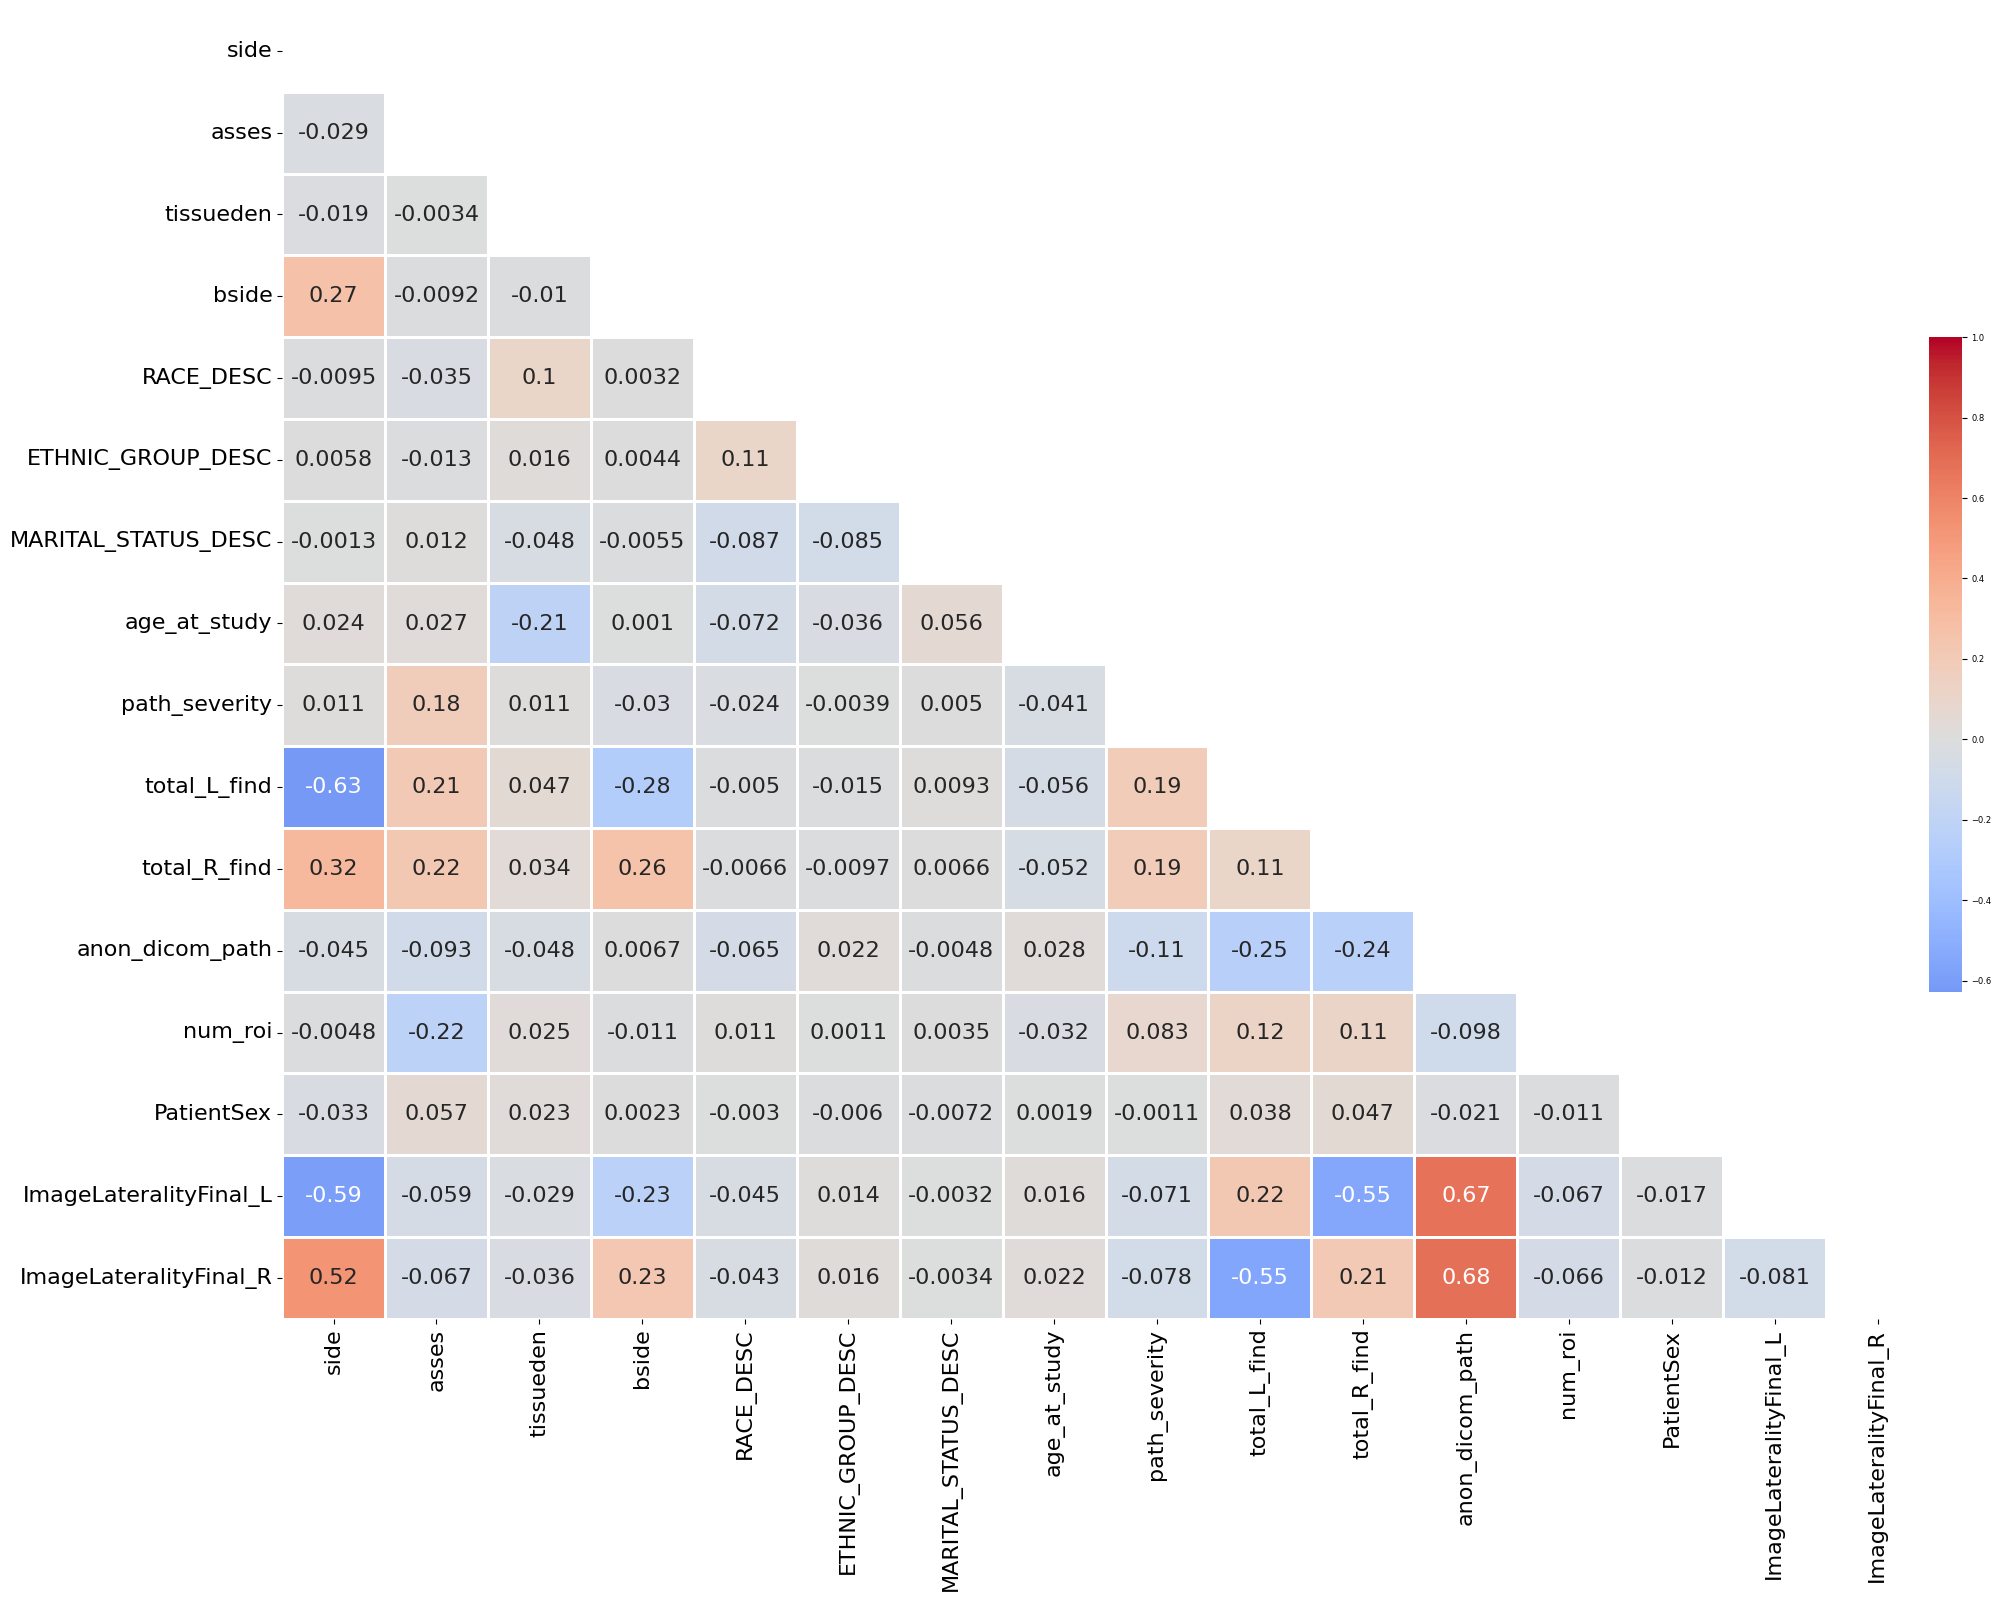

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
correlation_matrix = combined_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 17))

# Generate a custom diverging colormap
cmap = plt.get_cmap("coolwarm")

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(correlation_matrix, annot= True, ax=ax,annot_kws={"size": 16},mask=mask, cmap=cmap, vmax=1.0, center=0, linewidths=1,
                      cbar_kws={"shrink": 0.5, "pad": 0.000})
for item in ax.get_yticklabels():
    item.set_fontsize(16)
for item in ax.get_xticklabels():
    item.set_fontsize(16)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
# Adjust the position of the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
plt.show()